$ \textbf{Aluna:}$ Alessandra da Silva Dias Malizia   
$ \textbf{Data:}$ 19/10/2024

# Lista Prática 2

In [1]:
import io
import sys
import pandas as pd
import numpy as np
import requests
import json
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tsa.stattools import kpss
from pmdarima import auto_arima
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from statsmodels.tsa.stattools import acf, pacf

## Download da Série

In [2]:
url = 'http://www.ipeadata.gov.br/api/odata4/'
ticker = 'ANDA12_VFERTILIZ12'

# Dados
r = requests.get(url + "/Metadados('{}')/Valores".format(ticker))
data = json.loads(r.text)

series = pd.DataFrame(data['value'], columns=['VALDATA','VALVALOR']).rename(columns={'VALDATA':'date','VALVALOR':'value'}).set_index('date')
series.index = pd.to_datetime(series.index.map(lambda x: x.split('T')[0]))
series = series.div(1e6)

# Divisão entre período de teste e treino
series_train = series.iloc[:-12]
series_test = series.iloc[-12:]

In [3]:
# Metadados
r = requests.get(url + "/Metadados('{}')".format(ticker))
metadata = json.loads(r.text)

pd.DataFrame(index=['Metadados'], data={
    'Fonte':metadata['value'][0]['FNTNOME'], 
    'Unidade':metadata['value'][0]['UNINOME'],
    'Período da série': '{} a {}'.format(series.index[0].strftime('%d/%m/%Y'), series.index[-1].strftime('%d/%m/%Y')),
    'Período de treino': '{} a {}'.format(series_train.index[0].strftime('%d/%m/%Y'), series_train.index[-1].strftime('%d/%m/%Y')),
    'Período de teste': '{} a {}'.format(series_test.index[0].strftime('%d/%m/%Y'), series_test.index[-1].strftime('%d/%m/%Y')),
}).T

,Metadados
Fonte,Associação Nacional para Difusão de Adubos (Anda)
Unidade,Tonelada
Período da série,01/01/1998 a 01/07/2024
Período de treino,01/01/1998 a 01/07/2023
Período de teste,01/08/2023 a 01/07/2024


# Questão 1

## item (i): Série temporal de treino

Pela análise dos gráficos, o parâmetro 'd' é igual a 1, pois é o menor valor de 'd' que, por inspeção visual, confere estacionariedade à série.

A expressão da série diferenciada é :   $ z_t = (1-L)y_t $

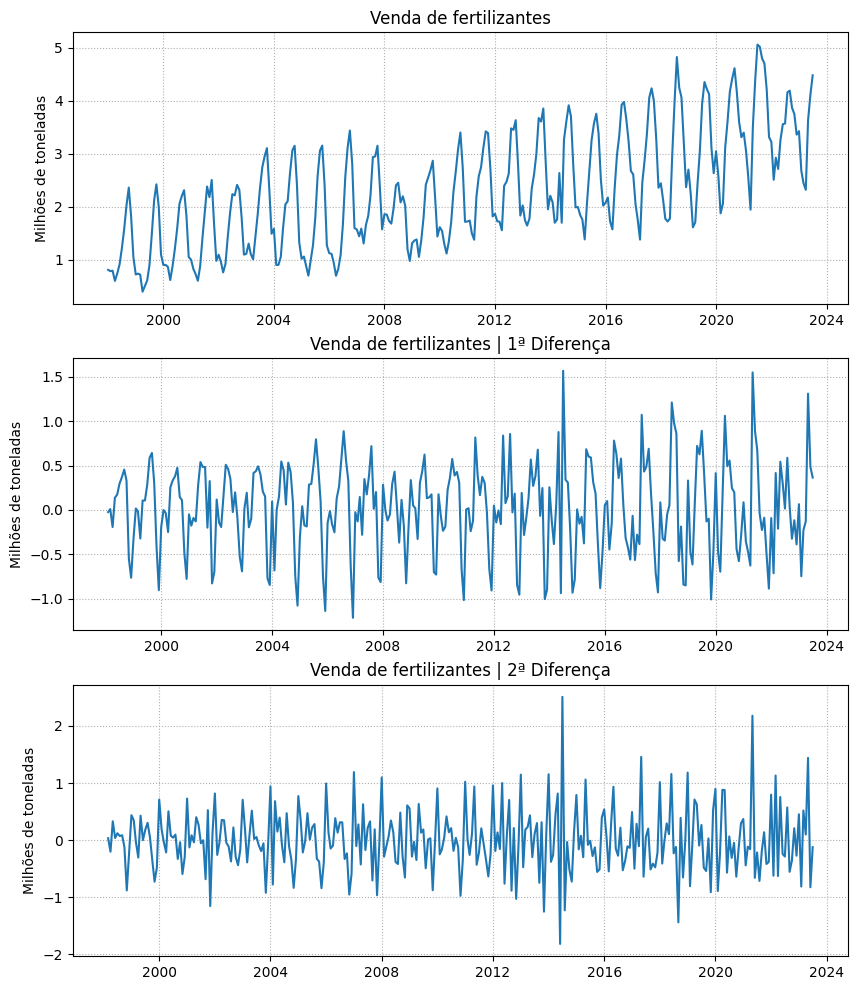

In [4]:
fig, ax = plt.subplots(3, figsize=(10,12))

ax[0].plot(series_train)
ax[0].set_ylabel('Milhões de toneladas')
ax[0].grid(axis='both', linestyle=':')
ax[0].set_title('Venda de fertilizantes')


ax[1].plot(series_train.diff())
ax[1].set_ylabel('Milhões de toneladas')
ax[1].grid(axis='both', linestyle=':')
ax[1].set_title('Venda de fertilizantes | 1ª Diferença')


ax[2].plot(series_train.diff().diff())
ax[2].set_ylabel('Milhões de toneladas')
ax[2].grid(axis='both', linestyle=':')
ax[2].set_title('Venda de fertilizantes | 2ª Diferença')

plt.show()

## item (ii): Teste de estacionariedade

Pelo resultado dos testes, o parâmetro 'd' também é igual a 1.

No primeiro teste, rejeitamos significância de 95% a hipótese nula da série original ser estacionária em torno de uma constante, em favor da hipótese alternativa de ter uma tendência. Esse resultado pode ser observado pelo p-valor (0.01) abaixo de 0.05.

Já no segundo teste, falhamos em rejeitar a hipótese nula com o mesmo nível de significância, já que o p-valor (0.10) é maior que 0.05. Com esse resultado, aceitamos a hipótese alternativa de que a série da primeira diferença é estacionária, obtendo d=1.

In [5]:
kpss_output = pd.DataFrame(columns = ['d', "Test Statistic", "p-value", "Lags Used"])

# parâmetro 'c' testa hipotese nula de level stationarity
# 1) série original (d=0)
kpsstest = kpss(series_train.dropna(), regression="c")
kpss_output.loc[kpss_output.shape[0]] = (0,) + kpsstest[0:3]

# 2) série da 1ª diferença (d=1)
kpsstest = kpss(series_train.diff().dropna(), regression="c")
kpss_output.loc[kpss_output.shape[0]] = (1,) + kpsstest[0:3]

kpss_output

C:\Users\aless\AppData\Local\Temp\ipykernel_19216\35467322.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpsstest = kpss(series_train.dropna(), regression="c")
C:\Users\aless\AppData\Local\Temp\ipykernel_19216\35467322.py:9: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(series_train.diff().dropna(), regression="c")


,d,Test Statistic,p-value,Lags Used
0,0.0,2.869743,0.01,9.0
1,1.0,0.006841,0.10,3.0


$\textbf{a)}$ Sim, pois a FACP possui pico no lag 12 e a FAC possui valores significativamente altos nos lags sazonais (12, 24, 36).

$\textbf{b)}$ O gráfico da FAC decai com uma senoide amortecida, enquanto a FACP é muito perto de zero a partir do lag 13. Esse comportamento pode sugerir um modelo ARIMA(12,1,0) como ponto de partida. Deve-se modelar também a sazonalidade.

$\textbf{c)}$ O decaimento dos picos da FAC e da FACP nos lags sazonais não sugere a necessidade de diferenciação sazonal, pois não há uma forte persistência dessas autocorrelações. Isso sugere que o efeito da sazonalidade é estável ao longo dos anos.

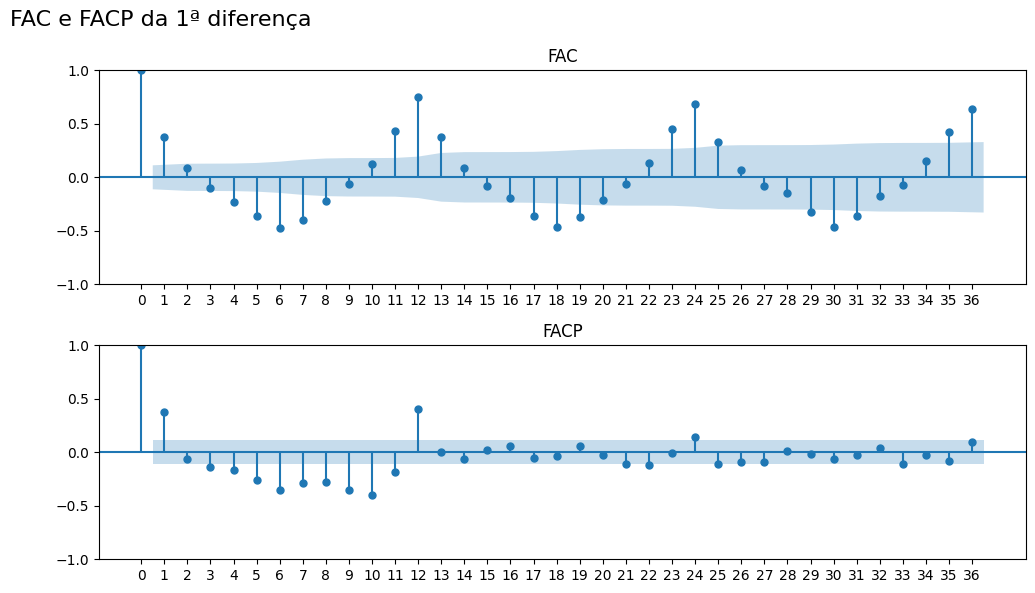

In [6]:
series_stationary = series_train.diff().dropna()

lags=36
fig, ax = plt.subplots(2, figsize=(10, 6))

plot_acf(series_stationary,lags=lags, ax=ax[0], title='FAC')
ax[0].set_xticks(np.arange(lags+1))
ax[0].set_xticklabels(np.arange(lags+1))

plot_pacf(series_stationary,lags=lags, ax=ax[1], title='FACP')
ax[1].set_xticks(np.arange(lags+1))
ax[1].set_xticklabels(np.arange(lags+1))

fig.suptitle('FAC e FACP da 1ª diferença', size=16, x=0.12)
plt.tight_layout()
plt.show()

## item (iii): Modelo não sazonal

$\textbf{a)}$ O modelo não sazonal selecionado pelo autoarima foi o SARIMA(2,1,2)(0,0,0), com AICc=232,23.    

A equação do modelo é: $ \phi_2(L)\Delta y_t = \theta_2(L) \epsilon_t  $ 

In [8]:
# estimação do auto arima
arima_models = {}
arima = auto_arima(series_train, d=1, seasonal=False, information_criteria='aicc',
                      error_action='ignore', trace=True)
arima_models['não sazonal'] = arima

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=232.419, Time=15.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=442.948, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=397.784, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=401.450, Time=1.34 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=441.127, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=399.622, Time=4.49 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=11.59 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=14.89 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=245.852, Time=6.97 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=399.009, Time=2.57 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=14.35 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=16.46 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=232.447, Time=12.19 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=232.026, Time=10.85 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=397.715, Time=

In [9]:
lb = acorr_ljungbox(arima.resid(), lags=[20])

arima_results = pd.DataFrame(columns=['Modelo','Expressão','AICc','ρ1','ρ2','ρ3','ρ6','ρ12','p-valor LB'])
arima_results.loc[arima_results.shape[0]] = ['não sazonal', 'SARIMA(2,1,2)(0,0,0)', arima.aicc(), 
                                             *acf(arima.resid())[[1,2,3,6,12]], lb.loc[20,'lb_pvalue']]

$\textbf{b)}$ Sim. A FAC e a FACP dos resíduos não possuem valores significativos nos lags de curto prazo, mas o correlograma apresenta um pico no lag sazonal, quando k=12. Isso indica que o modelo capturou bem a dependência da parte não sazonal, mas não capturou totalmente a sazonalidade. Esse resultado é esperado, já que o modelo foi estimado pelo auto arima sem lags sazonais.

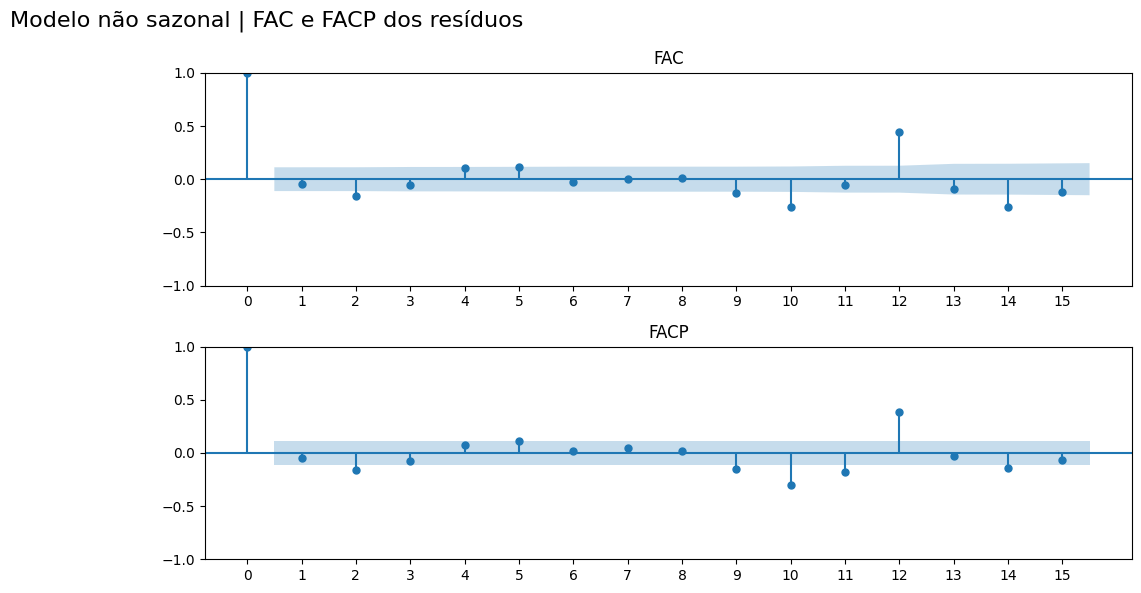

In [10]:
lags=15
fig, ax = plt.subplots(2, figsize=(10, 6))

plot_acf(arima.arima_res_.resid,lags=lags, ax=ax[0], title='FAC')
ax[0].set_xticks(np.arange(lags+1))
ax[0].set_xticklabels(np.arange(lags+1))

plot_pacf(arima.arima_res_.resid,lags=lags, ax=ax[1], title='FACP')
ax[1].set_xticks(np.arange(lags+1))
ax[1].set_xticklabels(np.arange(lags+1))

fig.suptitle('Modelo não sazonal | FAC e FACP dos resíduos', size=16, x=0.12)
plt.tight_layout()
plt.show()

## item (iv): Modelo sub-ótimo

$\textbf{a)}$ Foram comparados 81 modelos.

$\textbf{b)}$ O modelo sub-ótimo selecionado pelo autoarima foi o SARIMA(2,1,1)(1,0,2), com AICc = 53,73. 

A equação do modelo é: $ \phi_2(L)\Phi_1(L^{12})\Delta y_t = \theta_1(L)\Theta_2(L^{12}) \epsilon_t  $ 

In [11]:
# redirecionamento da saída para um buffer
original_stdout = sys.stdout
output_buffer = io.StringIO()
sys.stdout = output_buffer

# estimação do auto arima
arima = auto_arima(series_train, seasonal=True, m=12, information_criteria='aicc', 
                   error_action='ignore', trace=True)
arima_models['sub-ótimo'] = arima

# restauração da saída
output = output_buffer.getvalue()
sys.stdout = original_stdout

print('Número de modelos comparados: {}'.format(len(output.splitlines()[1:-3])))

Número de modelos comparados: 81


In [12]:
print(output)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=39.42 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=442.948, Time=0.20 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=166.804, Time=4.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=290.319, Time=4.21 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=441.127, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=397.784, Time=0.14 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=6.18 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=104.764, Time=6.15 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=289.658, Time=0.59 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=101.593, Time=8.61 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=104.205, Time=20.62 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=100.998, Time=12.34 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=245.024, Time=4.37 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=101.211, Time=7.55 sec
 ARIMA(2,1,0)(1,0,2)[12] intercept   :

$\textbf{c)}$ Como o p-valor do teste de Ljung-Box é maior que 0,05, o teste falha em rejeitar a hipótese nula de que os resíduos são independentes com nível de significância de 95%. Isso indica que o resíduo não possui estrutura de autocorrelação, e que o modelo capturou bem a série.

Esse resultado também pode ser observado no gráfico da FAC e da FACP,  pois não há valores significativamente altos, indicando que não há estrutura de dependência e correlação nos resíduos.

In [13]:
# teste de Ljung-Box
lb = acorr_ljungbox(arima.resid(), lags=[20])

arima_results.loc[arima_results.shape[0]] = ['sub-ótimo', 'SARIMA(2,1,1)(1,0,2)', arima.aicc(), 
                                             *acf(arima.resid())[[1,2,3,6,12]], lb.loc[20,'lb_pvalue']]
lb

,lb_stat,lb_pvalue
20,19.14379,0.512498


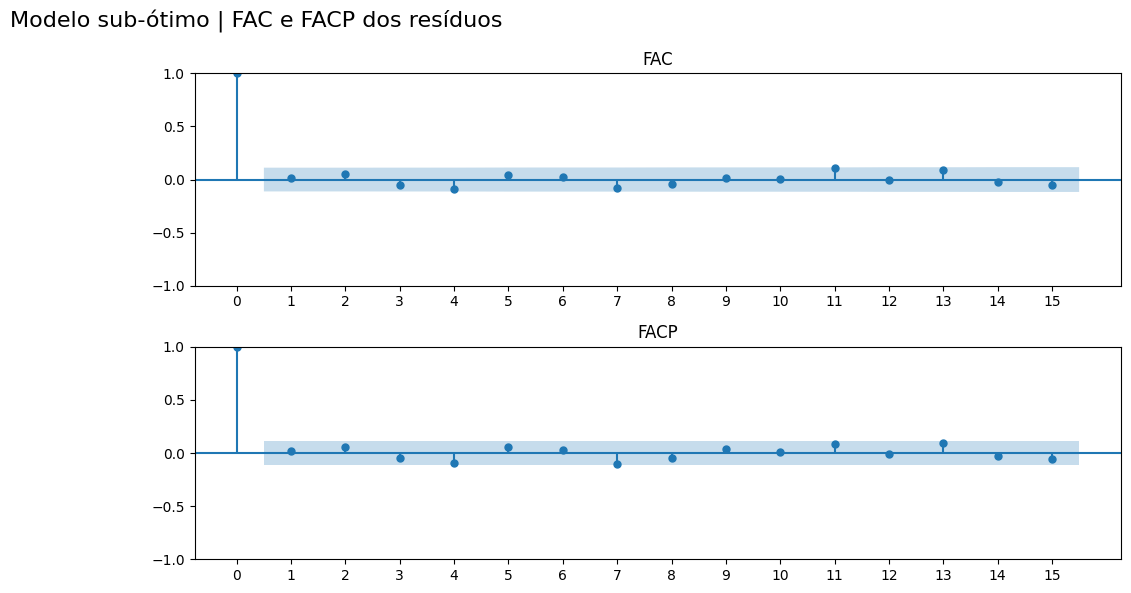

In [14]:
lags=15
fig, ax = plt.subplots(2, figsize=(10, 6))

plot_acf(arima.arima_res_.resid,lags=lags, ax=ax[0], title='FAC')
ax[0].set_xticks(np.arange(lags+1))
ax[0].set_xticklabels(np.arange(lags+1))

plot_pacf(arima.arima_res_.resid,lags=lags, ax=ax[1], title='FACP')
ax[1].set_xticks(np.arange(lags+1))
ax[1].set_xticklabels(np.arange(lags+1))

fig.suptitle('Modelo sub-ótimo | FAC e FACP dos resíduos', size=16, x=0.12)
plt.tight_layout()
plt.show()

## item (v): Modelo ótimo

$\textbf{a)}$ Foram comparados 95 modelos. Comparado com a busca do modelo sub-ótimo, o modelo ótimo fez uma busca um pouco maior e mais completa, considerando 14 modelos a mais.

$\textbf{b)}$ O modelo ótimo selecionado pelo autoarima foi o SARIMA(1,1,1)(2,0,1), com AIC = 56,644.   
As equações do modelo são:    
- $ (1-\phi_1L)(1-\Phi_1L^{12}-\Phi_2L^{24})(1-L) y_t = c + (1-\theta_1L)(1-\Theta_1L^{12}) \epsilon_t  $    
- $ y_t - \phi_1 y_{t-1} - y_{t-1} + \phi_1 y_{t-2} - \Phi_1 y_{t-12} + \Phi_1 \phi_1 y_{t-13} - \Phi_2 y_{t-24} + \Phi_2 \phi_1 y_{t-25} = $   
   $ c +\epsilon_t + \theta_1 \epsilon_{t-1} + \Theta_1 \epsilon_{t-12} + \theta_1 \Theta_1 \epsilon_{t-13} \epsilon_t  $

O segundo melhor modelo selecionado foi o SARIMA(1,1,1)(1,0,2), com AIC = 57,553.   
As equações do modelo são:    
- $ (1 - \phi_1 L)(1 - \Phi_1 L^{12})(1 - L) y_t = c + (1 + \theta_1 L)(1 + \Theta_1 L^{12} + \Theta_2 L^{24}) \epsilon_t  $    
- $ y_t - \phi_1 y_{t-1} - y_{t-1} + \phi_1 y_{t-2} - \Phi_1 y_{t-12} + \Phi_1 \phi_1 y_{t-13} - \Phi_1 y_{t-13} + \Phi_1 \phi_1 y_{t-14} = $   
$ c + \epsilon_t + \theta_1 \epsilon_{t-1} + \Theta_1 \epsilon_{t-12} + \theta_1 \Theta_1 \epsilon_{t-13} + \Theta_2 \epsilon_{t-24} + \theta_1 \Theta_2 \epsilon_{t-25}  $

Em todos os modelos estimados automaticamente, os parâmetros de d e D foram iguais aos estimados graficamente. Além disso, os três modelos possuem a mesma ordem MA não sazonal (q=1). Os modelos possuem uma pequena variação do AIC, mas diferem apenas em uma unidade da ordem de p, P e Q.

In [15]:
# redirecionamento da saída para um buffer
original_stdout = sys.stdout
output_buffer = io.StringIO()
sys.stdout = output_buffer

# estimação do auto arima
arima = auto_arima(series_train, seasonal=True, m=12, information_criteria='aicc', 
                   stepwise=False, error_action='ignore', trace=True)
arima_models['ótimo'] = arima

# restauração da saída
output = output_buffer.getvalue()
sys.stdout = original_stdout

print('Número de modelos comparados: {}'.format(len(output.splitlines()[1:-3])))

Número de modelos comparados: 95


In [16]:
print(output)

 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=442.948, Time=0.13 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=299.741, Time=0.67 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=246.039, Time=0.92 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=168.414, Time=0.47 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=104.355, Time=1.40 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=101.211, Time=4.52 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=142.164, Time=1.31 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=101.772, Time=4.80 sec
 ARIMA(0,1,0)(2,0,2)[12] intercept   : AIC=103.123, Time=6.05 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=401.450, Time=0.18 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=290.319, Time=2.62 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=245.206, Time=2.53 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=165.775, Time=1.16 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=104.258, Time=3.54 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=100.222, Time=5.18 sec
 ARIMA(0,1

In [17]:
# melhores modelos estimados
df_output = pd.DataFrame(columns=['model','AIC'],
             data=[[x.split(':')[0].strip(), x.split(':')[-1].strip()] for x in output.splitlines()[1:-3]])

df_output['AIC'] = df_output['AIC'].map(lambda x: float(x.split(',')[0].replace('AIC=','')))
df_output.sort_values('AIC').head(2)

,model,AIC
51,"ARIMA(1,1,1)(2,0,1)[12] intercept",56.644
49,"ARIMA(1,1,1)(1,0,2)[12] intercept",57.553


$\textbf{c)}$ Assim como no modelo sub-ótimo, o teste falha em rejeitar a hipótese nula de que os resíduos são independentes com nível de significância de 95%, pois o p-valor do teste de Ljung-Box é maior que 0,05. O teste aceita a hipótese alternativa de que o resíduo não é autocorrelatado e indica que o modelo capturou bem a série.

Esse resultado também pode ser observado no gráfico da FAC e da FACP,  pois não há autocorrelações significativas nos lags. Com esses resultados, o modelo pode ser considerado satisfatório.

In [18]:
lb = acorr_ljungbox(arima.resid(), lags=[20])

arima_results.loc[arima_results.shape[0]] = ['ótimo', 'SARIMA(1,1,1)(2,0,1)', arima.aicc(), 
                                             *acf(arima.resid())[[1,2,3,6,12]], lb.loc[20,'lb_pvalue']]
lb

,lb_stat,lb_pvalue
20,24.412018,0.224858


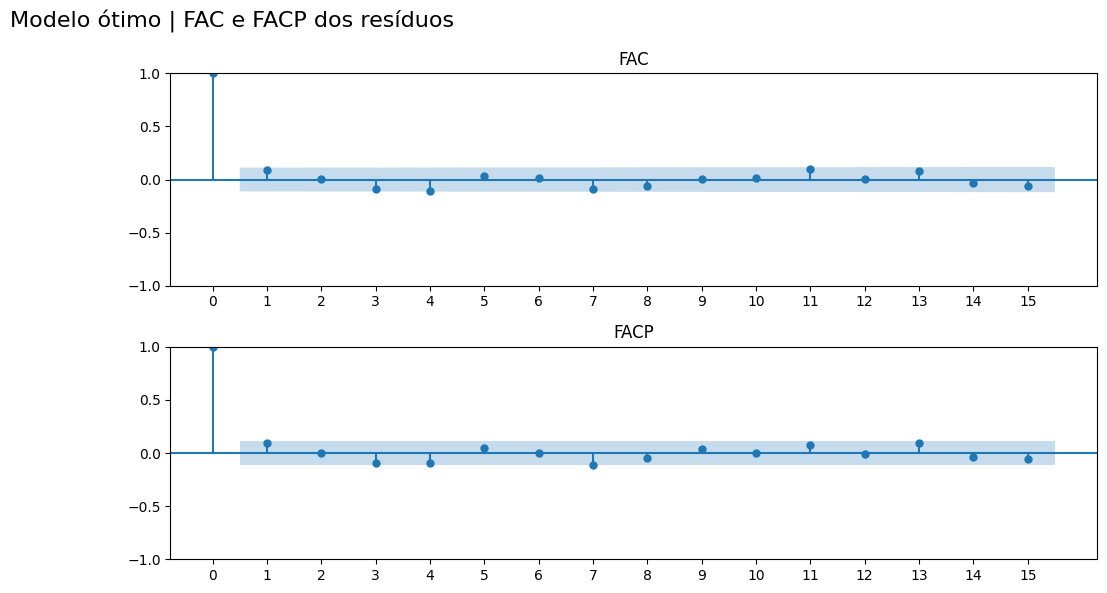

In [19]:
lags=15
fig, ax = plt.subplots(2, figsize=(10, 6))

plot_acf(arima.arima_res_.resid,lags=lags, ax=ax[0], title='FAC')
ax[0].set_xticks(np.arange(lags+1))
ax[0].set_xticklabels(np.arange(lags+1))

plot_pacf(arima.arima_res_.resid,lags=lags, ax=ax[1], title='FACP')
ax[1].set_xticks(np.arange(lags+1))
ax[1].set_xticklabels(np.arange(lags+1))

fig.suptitle('Modelo ótimo | FAC e FACP dos resíduos', size=16, x=0.12)
plt.tight_layout()
plt.show()

## item (vi): Comparação dos modelos

O modelo não sazonal possui um p-valor baixo do teste de Ljung-Box, alto coeficiente de correlação no lag sazonal 12 e alto AICc. Esses resultados indicam que o modelo não capturou a sazonalidade e teve um desempenho inferior aos outros dois modelos.

Já os modelos subótimo e ótimo possuem resultados e expressão parecidos. Ambos possuem baixos coeficientes de correlação com os lags de curto prazo e de sazonalidade e alto p-valor no teste de Ljung-Box. Esses resultados indicam que ambos capturaram bem a série.

Como o modelo sub-ótimo possui AICc mais baixo, eu escolheria ele. 

In [20]:
arima_results.round(2)

,Modelo,Expressão,AICc,ρ1,ρ2,ρ3,ρ6,ρ12,p-valor LB
0,não sazonal,"SARIMA(2,1,2)(0,0,0)",232.23,-0.05,-0.16,-0.06,-0.02,0.44,0.00
1,sub-ótimo,"SARIMA(2,1,1)(1,0,2)",53.73,0.02,0.05,-0.05,0.02,-0.00,0.51
2,ótimo,"SARIMA(1,1,1)(2,0,1)",57.02,0.09,0.01,-0.09,0.01,0.00,0.22


# Questão 2

Pelas métricas no período de teste, é possível observar que o modelo ARIMA não sazonal e os dois modelos naive possuem o pior desempenho, possuindo MASE maior que um e métricas mais altas de RMSE, MAD MAPE e SMape, apesar do modelo naive2 ser um pouco mais competitivo.

Apesar de o modelo ETS ser melhor que o modelo ARIMA não sazonal e que os modelos ingênuos, ele possui métricas um pouco mais altas que os modelos ótimo e sub-ótimo ARIMA. Já os modelos ótimo e subótimo ARIMA possuem um desempenho muito parecido no período de teste, com a maioria das métricas diferindo na segunda ou terceira casa decimal. Assim, é difícil determinar se o melhor modelo escolhido (sub-ótimo) possui performance fora da amostra melhor que o ótimo.

In [21]:
df_predictions = pd.DataFrame(columns=['series','não sazonal','sub-ótimo','ótimo',
                                       'melhor modelo ETS','naive1','naive2'])
df_predictions['series'] = series_test['value']

def calculate_metrics(model_name, y_true, y_pred):
    df_predictions[model_name] = y_pred 
    resid = y_true.sub(y_pred)
    mape = y_true.sub(y_pred).abs().div(y_true).mean()
    smape = y_true.sub(y_pred).abs().div(
        y_true.add(y_pred).div(2)
    ).mean()
    mase = y_true.sub(y_pred).abs().mean()/(
        series_train['value'].sub(series_train['value'].shift()).abs().mean() # naive calculado insample
    )
    return model_name, resid.pow(2).sum()**0.5, resid.abs().mean(), 100*mape, 100*smape, mase

In [22]:
df_metrics_test = pd.DataFrame(columns=['model','RMSE','MAD','MAPE','SMape','MASE'])
# 3 arima models
for name, model in arima_models.items():
    df_metrics_test.loc[df_metrics_test.shape[0]] = [*calculate_metrics(name, series_test['value'], model.predict(12).values)]
# melhor modelo ETS
best_model_ets = ETSModel(series_train['value'],  error='add', trend='add', seasonal='add', 
            damped_trend=True, seasonal_periods=12,freq='M', dates=series_train.index.to_period('M'))
best_fit_ets = best_model_ets.fit()
df_metrics_test.loc[df_metrics_test.shape[0]] = [*calculate_metrics('melhor modelo ETS', series_test['value'], best_fit_ets.forecast(12).values)]
# naive predictions
predictions = {
    'naive1': [series_train['value'].iloc[-1]]*12, # ultima observação de treino da ST
    'naive2': series_train['value'].iloc[-12:].values # última observação de treino da ST para cada horizonte (12 meses)
}
for model, pred in predictions.items():
    df_metrics_test.loc[df_metrics_test.shape[0]] = [*calculate_metrics(model, series_test['value'], pred)]

df_metrics_test.round(4)

C:\Users\aless\Desktop\Codes\venv12\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:595: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = to_offset(freq)


,model,RMSE,MAD,MAPE,SMape,MASE
0,não sazonal,2.8577,0.7356,21.8996,20.7119,1.8786
1,sub-ótimo,1.1275,0.2570,7.7274,7.4559,0.6563
2,ótimo,1.1296,0.2504,7.7200,7.3792,0.6395
3,melhor modelo ETS,1.4164,0.3159,10.3434,9.5176,0.8069
4,naive1,4.1941,0.9810,33.7351,25.9715,2.5053
5,naive2,1.8929,0.4031,9.8661,10.3159,1.0296


In [23]:
# previsões
df_predictions.round(2)

,series,não sazonal,sub-ótimo,ótimo,melhor modelo ETS,naive1,naive2
date,,,,,,,
2023-08-01,5.52,4.36,4.81,4.82,4.81,4.48,4.16
2023-09-01,4.89,4.07,4.73,4.76,4.76,4.48,4.19
2023-10-01,4.71,3.68,4.47,4.52,4.64,4.48,3.87
2023-11-01,4.00,3.30,3.94,4.00,4.13,4.48,3.75
2023-12-01,3.61,3.03,3.37,3.40,3.46,4.48,3.36
2024-01-01,3.71,2.94,3.45,3.48,3.49,4.48,3.43
2024-02-01,2.87,3.03,2.98,2.99,3.06,4.48,2.68
2024-03-01,2.09,3.27,2.72,2.75,2.95,4.48,2.45
2024-04-01,2.31,3.60,2.57,2.60,2.87,4.48,2.32


# Questão 3

$\textbf{a)}$ As funções arroots() e maroots() da classe ARIMA retornam as raízes dos polinômios $\phi(L)\Phi(L)$ e $\theta(L)\Theta(L)$, respectivamente. Dessa forma, a condição de estacionariedade será satisfeita se as raízes do polinômio AR sazonal e não sazonal estiverem fora do círculo unitário, ou seja, tiverem módulo maior que um. Analogamente, a condição de invertibilidade será satisfeita se as raízes do polinômio MA sazonal e não sazonal tiverem módulo maior que um.

Pelos resultados, ambas as condições são satisfeitas, pois o módulo de todas as raízes é maior que um, confirmando que o modelo é estacionário e invertível.

In [24]:
# módulo das raízes da parte AR
np.abs(arima_models['sub-ótimo'].arroots())

array([1.00061379, 1.00061379, 1.00061379, 1.00061379, 1.00061379,
       1.00061379, 1.00061379, 1.00061379, 1.00061379, 1.00061379,
       1.00061379, 1.00061379, 1.80869894, 5.61464823])

In [25]:
# módulo das raízes da parte MA
np.abs(arima_models['sub-ótimo'].maroots())

array([1.01626565, 1.01626565, 1.01626565, 1.15732193, 1.15732193,
       1.15732193, 1.15732193, 1.01626565, 1.01626565, 1.15732193,
       1.15732193, 1.01626565, 1.01626565, 1.15732193, 1.15732193,
       1.01626565, 1.01626565, 1.15732193, 1.15732193, 1.01626565,
       1.01626565, 1.15732193, 1.15732193, 1.01626565, 1.02169825])

$ \textbf{b)} $ Apesar das projeções do melhor modelo ETS e melhor modelo ARIMA serem parecidas, o modelo ARIMA possui intervalo de confiança menor que o modelo ETS para horizontes maiores. Por isso, as previsões desse modelo são a mais precisa.

Como esperado, a largura do intervalo de confiança do modelo ARIMA não cresce indefinidamente conforme aumenta o horizonte de previsão. Esse comportamento pode ser observado pelo gráfico, em contraste com a largura do intervalo de confiança do modelo ETS, que aumenta com o horizonte.

In [26]:
df_predictions = pd.DataFrame(columns = ['mean_ets','lower_ets','upper_ets','mean_arima','lower_arima','upper_arima'])

# estimação do melhor modelo ETS na série completa
best_model = ETSModel(series['value'], 
                     error='add', trend='add', seasonal='add', 
                     damped_trend=True, seasonal_periods=12,
                    freq='M', dates=series_train.index.to_period('M'))
best_fit = best_model.fit()
df_predictions[['mean_ets','lower_ets','upper_ets']] = best_fit.get_prediction('2024-08-01','2026-07-01').summary_frame(alpha=0.05)


# estimação do auto arima na série completa
arima = auto_arima(series, seasonal=True, m=12, information_criteria='aicc', 
                   stepwise=False, error_action='ignore', trace=False)

pred = arima.predict(n_periods=24, return_conf_int=True, alpha=0.05)
df_predictions['mean_arima'] = pred[0].values
df_predictions[['lower_arima','upper_arima']] = pred[1]
df_predictions

C:\Users\aless\Desktop\Codes\venv12\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:595: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = to_offset(freq)


,mean_ets,lower_ets,upper_ets,mean_arima,lower_arima,upper_arima
2024-08,5.015643,4.482570,5.548716,5.207343,4.711814,5.702871
2024-09,4.770458,4.072719,5.468196,4.957016,4.359577,5.554455
2024-10,4.676265,3.845882,5.506649,4.774703,4.134252,5.415154
2024-11,4.154778,3.210185,5.099371,4.132084,3.470675,4.793493
2024-12,3.553019,2.506601,4.599437,3.592256,2.919427,4.265086
2025-01,3.567503,2.428319,4.706687,3.683169,3.003403,4.362935
2025-02,3.047031,1.822082,4.271979,3.130375,2.445924,3.814826
2025-03,2.879983,1.574891,4.185076,2.699794,2.011857,3.387732
2025-04,2.933374,1.552780,4.313969,2.681721,1.990967,3.372475
2025-05,3.866462,2.414284,5.318640,3.537767,2.844586,4.230948


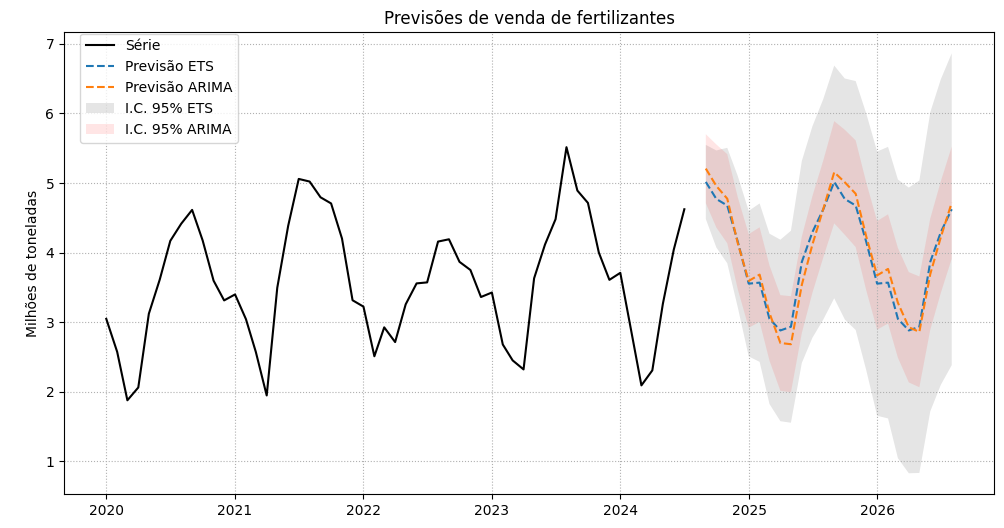

In [27]:
# gráfico
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(series.loc['2020':,'value'], label='Série', color='black')
ax.plot(df_predictions['mean_ets'], label='Previsão ETS', color='C0', linestyle='--')
ax.plot(df_predictions['mean_arima'], label='Previsão ARIMA', color='C1', linestyle='--')
ax.fill_between(df_predictions.index, df_predictions['lower_ets'], df_predictions['upper_ets'], facecolor="black", alpha=0.1,label = 'I.C. 95% ETS')
ax.fill_between(df_predictions.index, df_predictions['lower_arima'], df_predictions['upper_arima'], facecolor="red", alpha=0.1,label = 'I.C. 95% ARIMA')

ax.set_ylabel('Milhões de toneladas')
ax.grid(axis='both', linestyle=':')
fig.legend(loc=(0.08,0.73))
ax.set_title('Previsões de venda de fertilizantes')
plt.show()
